# CMAP analysis

In this notebook we analyze available gene expressio data from the CMAP data set of U2OS cells in various overexpression conditions including those covered in our structural regulators. The idea is to better understand the clustering of the gene expression profiles and the corresponding co-clustering with the currently inferred pyhsical space estimate. Additionally, we aim to preprocess the data such that it can be used later to infer the regulatory network of U2OS cells which will be the basis for the modelling of the regulatory space.

---

## 0. Environmental setup

First, we setup the environment by loading required packages.

In [1]:
import pandas as pd
import numpy as np
from venn import venn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from cmapPy.pandasGEXpress.parse import parse

import sys
from yellowbrick.cluster import KElbowVisualizer

sys.path.append("../../../..")
from src.utils.notebooks.ppi.embedding import plot_tsne_embs
from src.utils.notebooks.images.embedding import *
from src.utils.torch.network import *
from src.utils.notebooks.ppi.embedding import *

%load_ext nb_black

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we read the CMAP gene signature data and associated metadata.

In [2]:
sig_info = pd.read_csv("../../../../data/resources/gex/cmap/siginfo_beta.txt", sep="\t")
gene_info = pd.read_csv(
    "../../../../data/resources/gex/cmap/geneinfo_beta.txt", sep="\t"
)
cell_info = pd.read_csv(
    "../../../../data/resources/gex/cmap/cellinfo_beta.txt", sep="\t"
)
l5_oe_gex_data = parse(
    "../../../../data/resources/gex/cmap/level5_beta_trt_oe_n34171x12328.gctx"
).data_df.transpose()

<ipython-input-2-b70447eac3d7>:1: DtypeWarning: Columns (0,3,4,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  sig_info = pd.read_csv("../../../../data/resources/gex/cmap/siginfo_beta.txt", sep="\t")


<IPython.core.display.Javascript object>

We are particularly interested in the CMAP gene signatures corresponding to the overexpression of any of the genes contained in the inferred gene-gene interactome. Thus we also load the corresponding graph.

In [3]:
spearman_interactome = nx.read_gpickle(
    "../../../../data/experiments/rohban/interactome/inference_results/spearman_sol_cv.pkl"
)
print(spearman_interactome)

spearman_nodes = list(spearman_interactome.nodes())

Graph named 'spearman_sol' with 249 nodes and 526 edges


<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

To preprocess the data, we briefly filter out any signatures of the CMAP data set that are not related to any overexpression experiments related to our cell type of interest: U2OS.

In [27]:
sig_info = sig_info.loc[
    (sig_info["project_code"] == "TA") & (sig_info["cell_iname"] == "U2OS")
]
sig_info = sig_info.loc[sig_info["pert_type"].isin(["trt_oe"])]
# sig_info = sig_info.loc[sig_info["cmap_name"].isin(list(spearman_nodes))]
sig_info.index = np.array(sig_info.sig_id)
sig_info.head(5)

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
TA.OE005_U2OS_72H:BRDN0000464889:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000464889,...,U2OS,O02,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:O02|TA.OE005_U2OS_72H...,NaN,TA,SMAD3,1,1.0,0.0
TA.OE005_U2OS_72H:BRDN0000407676:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000407676,...,U2OS,I01,TA.OE005_U2OS_72H_X1_B15,TA.OE005_U2OS_72H_X1_B15:I01,NaN,TA,WNT5A,0,0.0,0.0
TA.OE005_U2OS_72H:BRDN0000464938:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000464938,...,U2OS,J01,TA.OE005_U2OS_72H_X1_B15,TA.OE005_U2OS_72H_X1_B15:J01,NaN,TA,HSP90B1,0,0.0,0.0
TA.OE005_U2OS_72H:BRDN0000459386:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000459386,...,U2OS,G04,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:G04|TA.OE005_U2OS_72H...,NaN,TA,PIK3CA,1,1.0,0.0
TA.OE005_U2OS_72H:BRDN0000399961:1,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000399961,...,U2OS,O13,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:O13|TA.OE005_U2OS_72H...,NaN,TA,TP53,0,0.0,0.0


<IPython.core.display.Javascript object>

In [28]:
len(sig_info.cmap_name)

324

<IPython.core.display.Javascript object>

We find 324 gene signatuures associated to the overexpression of 188 overexpressed genes.

We will construct averaged gene sigantures for each overexpression conditions described above.

In [29]:
gene_id_symbol_dict = dict(
    zip(gene_info.loc[:, "gene_id"].astype(str), gene_info.loc[:, "gene_symbol"])
)
l5_oe_gex_data = l5_oe_gex_data.rename(gene_id_symbol_dict, axis=1)
l5_data = l5_oe_gex_data.loc[set(sig_info.sig_id)].copy()
l5_data["labels"] = np.array(sig_info.loc[l5_data.index, "cmap_name"])
mean_l5_data = l5_data.copy()
mean_l5_data["labels"] = np.array(sig_info.loc[mean_l5_data.index, "cmap_name"])
mean_l5_data = mean_l5_data.groupby("labels").mean()
mean_l5_data.head()

rid,NAT2,ADA,CDH2,AKT3,MED6,NAALAD2,NAALADL1,ACOT8,ABI1,GNPDA1,...,REC8,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,PTBP3,KCNE2,DGCR2,SCO2
labels,,,,,,,,,,,,,,,,,,,,,
ACVR1B,0.382983,0.273100,0.556467,0.014800,0.108117,0.368000,0.534183,0.390683,-0.214333,0.201783,...,0.541300,-0.179367,-0.463917,0.169100,-1.299350,-0.120550,-0.093567,0.095350,0.599783,0.324317
ADAM17,-0.321200,-0.866750,-0.070550,0.100850,-0.393200,1.122850,0.036250,0.468750,-0.743700,0.034900,...,0.345050,-0.369750,-0.322050,-0.210700,1.434200,0.058050,-0.212450,0.599150,-0.007250,1.124700
AKT1,-0.516100,-0.810000,0.099400,-0.500933,-0.105000,-0.560267,0.071867,0.357167,-0.135917,-0.618183,...,0.356483,0.234067,0.362783,0.904867,-0.072367,-0.444233,0.559650,0.015817,-0.102150,0.212633
AKT1S1,0.161675,-0.486725,0.648050,0.880625,-0.174125,1.154400,0.192925,0.297125,-0.207900,0.863800,...,0.080525,0.684025,-0.573075,0.495225,-1.047250,0.352625,0.582375,-0.536525,-0.496625,0.970000
AKT2,-1.160950,0.428450,-0.063650,-1.065950,-0.131850,-0.108450,0.117800,-0.130300,-0.584200,0.209750,...,-0.220450,1.569800,-1.108100,0.556550,0.411900,-0.621400,0.083950,-0.689700,-0.603000,1.102050


<IPython.core.display.Javascript object>

The gene signatures describe the differential gene expression profiles in the different overexpression settings. However, for only 978 genes the differential expression was computed based on measured quantities while the differential expression of the other genes contained in the signatures were inferred based on those 978 genes. Thus, we focus on the 978 landmark genes and subset the signatures accordingly to avoid any bias due to the inference of the expression of the other genes.

In [30]:
l1000_genes = set(gene_info.loc[gene_info.feature_space == "landmark", "gene_symbol"])
mean_l5_data = mean_l5_data.loc[:, l1000_genes]

<IPython.core.display.Javascript object>

In [31]:
contained_nodes = set(spearman_nodes).intersection(mean_l5_data.index)

<IPython.core.display.Javascript object>

---

## 3. Clustering of the gene signatures.


We next are interested in the clustering of the different overexpression conditions of the genes contained in the inferred interactome based on the CMap gene signatures. As proposed by Subramanian et al. (2017) we therefore use hierarchical clustering with complete linkage and the cosine distance.

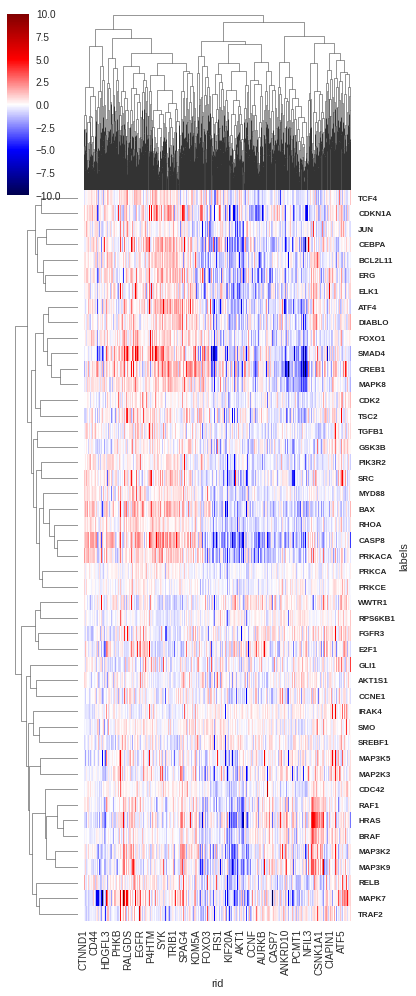

<IPython.core.display.Javascript object>

In [32]:
ax = sns.clustermap(
    mean_l5_data.loc[contained_nodes],
    figsize=[6, 14],
    metric="cosine",
    cmap="seismic",
    method="complete",
    # row_colors=np.array(struct_colors.loc[mean_l5_data.loc[oe_targets].index]),
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=8,
    fontweight="bold",
)
plt.show()

The above clustermap shows a similar grouping of the genes as observed when clustering the gene perturbation embeddings.

---

We next identify the optimal number of clusters by looking for a local maxima of the Calinski-Harabasz and local minima of the Silhouette score within the interval of (2,15] clusters.

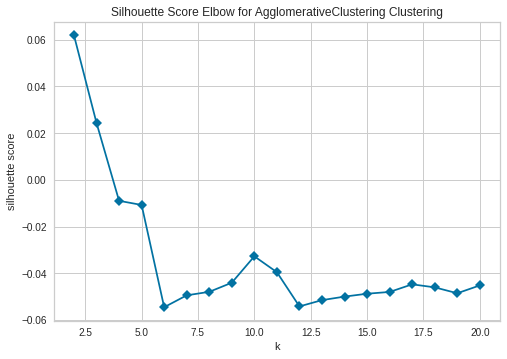

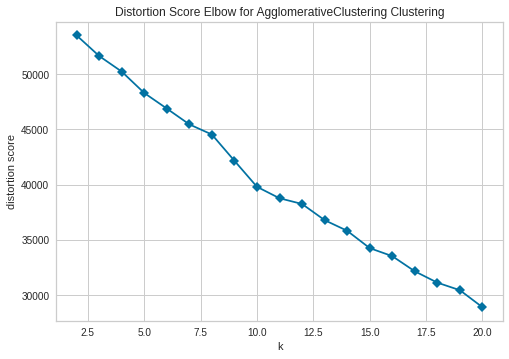

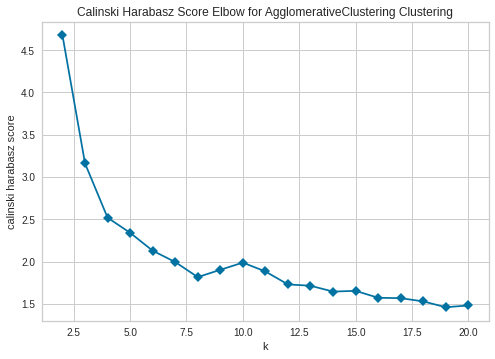

<IPython.core.display.Javascript object>

In [33]:
model = AgglomerativeClustering(affinity="cosine", linkage="complete")
# model = KMeans(random_state=1234)
visualizer = KElbowVisualizer(
    model, k=20, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(mean_l5_data.loc[contained_nodes])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=20, metric="distortion", timings=False, locate_elbow=False
)

visualizer.fit(mean_l5_data.loc[contained_nodes])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=20, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(mean_l5_data.loc[contained_nodes])
ax = visualizer.show()

We note that the above plots suggests dividing into two large clusters. However, we decide to overcluster the set of gene targets to give rise to smaller structures in the observed signature space. To this end, we at look the next local optima of the Calinski-Harabasz score which is achieved by a solution comprising of 10 clusters.

In [36]:
model = AgglomerativeClustering(n_clusters=10, affinity="cosine", linkage="complete")
l5_cluster_labels = model.fit_predict(mean_l5_data.loc[contained_nodes])
mean_l5_clusters = pd.DataFrame(
    l5_cluster_labels,
    index=mean_l5_data.loc[contained_nodes].index,
    columns=["cluster"],
)

<IPython.core.display.Javascript object>

In [37]:
lut = dict(
    zip(
        list(np.unique(mean_l5_clusters)),
        [
            "tab:blue",
            "tab:red",
            "tab:green",
            "gold",
            "tab:orange",
            "tab:cyan",
            "purple",
            "tab:pink",
            "tab:olive",
            "tab:cyan",
            "tab:brown",
        ],
    )
)
mean_l5_colors = pd.Series(
    np.array(mean_l5_clusters.cluster),
    index=mean_l5_clusters.index,
).map(lut)

<IPython.core.display.Javascript object>

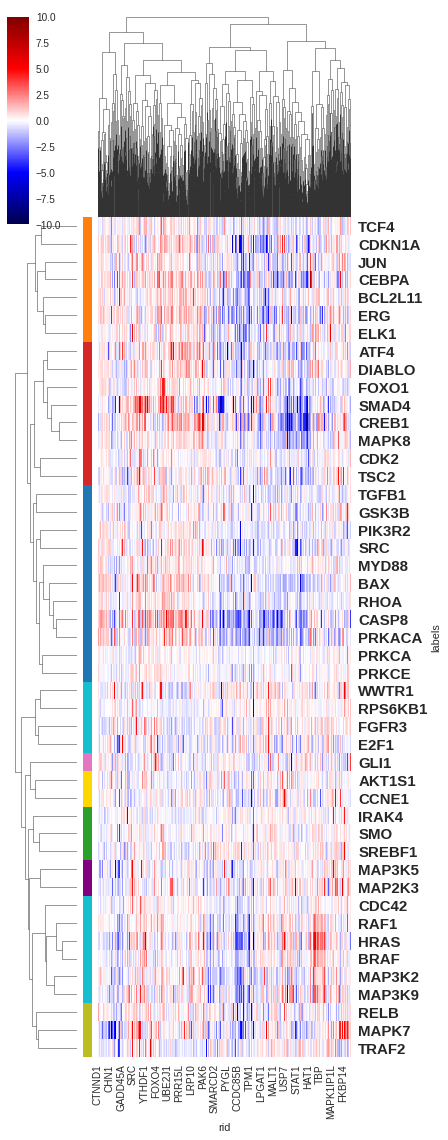

<IPython.core.display.Javascript object>

In [39]:
ax = sns.clustermap(
    mean_l5_data.loc[contained_nodes],
    figsize=[6, 16],
    metric="cosine",
    cmap="seismic",
    method="complete",
    row_colors=np.array(mean_l5_colors),
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
plt.show()

---

## 4. Data export

Finally, we export the CMap gene signatures for the selected nodes as well as the identified clustering structure.